In [1]:
import os
os.chdir("../")

In [2]:
from src.entity import AgentState, RewrittenQuestion
from langchain_core.prompts import ChatPromptTemplate
from langchain_cohere import ChatCohere

In [3]:
from src.get_current_user import get_current_user
from src.check_revelance import check_relevance
from src.convert_to_sql import convert_nl_to_sql
from src.execute_sql import execute_sql
from src.generate_human_readable_answer import generate_human_readable_answer
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
load_dotenv()

True

In [4]:
def regenerate_query(state: AgentState):
    question = state["question"]
    print("Regenerating the SQL query by rewriting the question.")
    system = """You are an assistant that reformulates an original question to enable more precise SQL queries. Ensure that all necessary details, such as table joins, are preserved to retrieve complete and accurate data.
    """
    rewrite_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                f"Original Question: {question}\nReformulate the question to enable more precise SQL queries, ensuring all necessary details are preserved.",
            ),
        ]
    )
    llm = ChatCohere(model = "command-r-plus-08-2024",temperature=0)
    structured_llm = llm.with_structured_output(RewrittenQuestion)
    rewriter = rewrite_prompt | structured_llm
    rewritten = rewriter.invoke({})
    state["question"] = rewritten.question
    state["attempts"] += 1
    print(f"Rewritten question: {state['question']}")
    return state

In [5]:
def relevance_router(state: AgentState):
    if state["relevance"].lower() == "relevant":
        return "convert_to_sql"
    else:
        return "END"

In [6]:
def execute_sql_router(state: AgentState):
    if not state.get("sql_error", False):
        return "generate_human_readable_answer"
    else:
        return "regenerate_query"

In [7]:
def check_attempts_router(state: AgentState):
    if state["attempts"] < 3:
        return "convert_to_sql"
    else:
        return "end_max_iterations"

In [8]:
def end_max_iterations(state: AgentState):
    state["query_result"] = "Please try again."
    print("Maximum attempts reached. Ending the workflow.")
    return state

In [9]:
workflow = StateGraph(AgentState)

workflow.add_node("get_current_user", get_current_user)
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("convert_to_sql", convert_nl_to_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_human_readable_answer", generate_human_readable_answer)
workflow.add_node("regenerate_query", regenerate_query)
workflow.add_node("end_max_iterations", end_max_iterations)

workflow.add_edge("get_current_user", "check_relevance")

workflow.add_conditional_edges(
    "check_relevance",
    relevance_router,
    {
        "convert_to_sql": "convert_to_sql",
        "END": END,
    },
)

workflow.add_conditional_edges(
    "regenerate_query",
    check_attempts_router,
    {
        "convert_to_sql": "convert_to_sql",
        "max_iterations": "end_max_iterations",
    },
)

workflow.add_edge("convert_to_sql", "execute_sql")

workflow.add_conditional_edges(
    "execute_sql",
    execute_sql_router,
    {
        "generate_human_readable_answer": "generate_human_readable_answer",
        "regenerate_query": "regenerate_query",
    },
)


workflow.add_edge("generate_human_readable_answer", END)
workflow.add_edge("end_max_iterations", END)
workflow.set_entry_point("get_current_user")

app = workflow.compile()

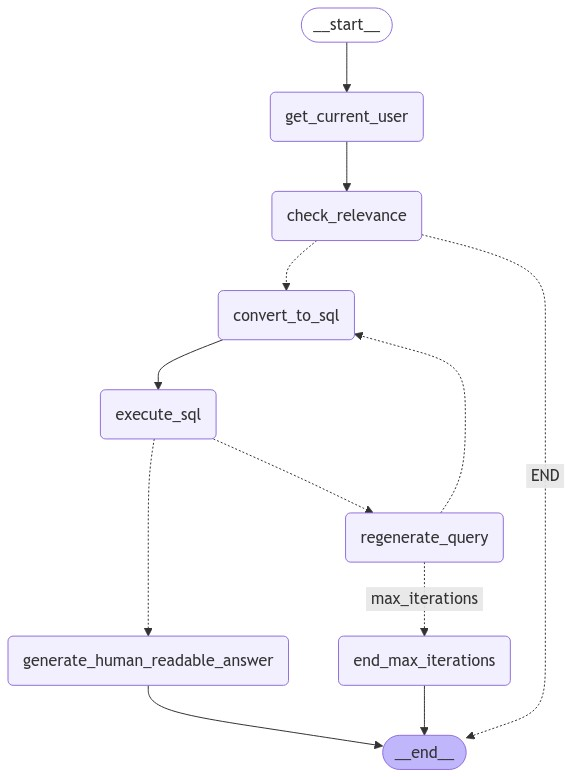

In [10]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [11]:
config = {"configurable": {"current_user_id": "2"}}
user_question_1 = "how much do i need to pay for my order?"
result_1 = app.invoke({"question": user_question_1, "attempts": 0}, config=config)
print("Result:", result_1)

Retrieving the current user based on user ID.
Current user set to: User 2
Retrieved database schema.
Checking relevance of the question: how much do i need to pay for my order?
Relevance determined: relevant
Retrieved database schema.
Converting question to SQL for user 'User 2': how much do i need to pay for my order?
Generated SQL query: SELECT SUM(price) FROM food INNER JOIN orders ON food.id = orders.food_id WHERE orders.user_id = 2;
Executing SQL query: SELECT SUM(price) FROM food INNER JOIN orders ON food.id = orders.food_id WHERE orders.user_id = 2;
Raw SQL Query Result: [{'SUM(price)': 282.1}]
SQL SELECT query executed successfully.
Generating a human-readable answer.
Generated human-readable answer.
Result: {'question': 'how much do i need to pay for my order?', 'sql_query': 'SELECT SUM(price) FROM food INNER JOIN orders ON food.id = orders.food_id WHERE orders.user_id = 2;', 'query_result': 'Hello User 2, unfortunately, there is no order data available for your user ID.', 'qu

In [14]:
result_1['sql_query']

'SELECT SUM(price) FROM food INNER JOIN orders ON food.id = orders.food_id WHERE orders.user_id = 2;'

In [13]:
result_1['query_result']

'Hello User 2, unfortunately, there is no order data available for your user ID.'